In [1]:
import numpy as np
import pandas as pd


class Alpha:

    def __init__(self, ohlc):
        df = ohlc
        self.open = df['Open'].values
        self.close = df['Close'].values
        self.high = df['High'].values
        self.low = df['Low'].values
        self.vol = df['Volume'].values
        self.upper = np.max([self.open, self.close], axis=0)
        self.lower = np.min([self.open, self.close], axis=0)
        self.T = len(self.close)

    # alpha should have the same length with the data.

    def close_return(self):
        signal = np.concatenate([[np.nan], (self.close[1:]-self.close[:-1])/self.close[:-1]])
        return signal

    def open_return(self):
        signal = np.concatenate([[np.nan], (self.open[1:]-self.open[:-1])/self.open[:-1]])
        return signal

    def close_open_diff(self):
        signal = (self.close - self.open) / self.close
        return signal

    def upper_lower_diff(self):
        signal = (self.upper - self.lower) / self.close
        return signal

    def high_low_diff(self):
        signal = (self.high - self.low) / self.close
        return signal

    def high_upper_diff(self):
        signal = (self.high - self.upper) / self.close
        return signal

    def lower_low_diff(self):
        signal = (self.lower - self.low)/self.close
        return signal

    def moving_average(self, window=10):
        signal = pd.DataFrame({'signal': self.close}).rolling(window=window).mean().values.reshape(-1)
        return signal

    def moving_std(self, window=10):
        signal = pd.DataFrame({'signal': self.close}).rolling(window=window).std().values.reshape(-1)
        return signal

    def moving_var(self, window=10):
        signal = pd.DataFrame({'signal': self.close}).rolling(window=window).var().values.reshape(-1)
        return signal

    def moving_med(self, window=10):
        signal = pd.DataFrame({'signal': self.close}).rolling(window=window).median().values.reshape(-1)
        return signal

    def moving_max(self, window=10):
        signal = pd.DataFrame({'signal': self.close}).rolling(window=window).max().values.reshape(-1)
        return signal

    def moving_min(self, window=10):
        signal = pd.DataFrame({'signal': self.close}).rolling(window=window).min().values.reshape(-1)
        return signal

    def moving_average_diff(self, window1=10, window2=20):
        signal1 = pd.DataFrame({'signal': self.close}).rolling(window=window1).mean().values.reshape(-1)
        signal2 = pd.DataFrame({'signal': self.close}).rolling(window=window2).mean().values.reshape(-1)
        signal = signal1-signal2
        return signal

    def bollinger_upper_bound(self, window=10, width=2):
        signal = self.moving_average(window=window) + width*self.moving_std(window=window)
        return signal

    def bollinger_lower_bound(self, window=10, width=2):
        signal = self.moving_average(window=window) - width * self.moving_std(window=window)
        return signal

In [2]:
df = pd.read_csv('./data/^SP500TR.csv')
alpha = Alpha(df)
print(alpha.bollinger_upper_bound(window=10, width=2))

[          nan           nan           nan ... 6281.87772951 6307.27976204
 6327.84716729]


In [3]:
from alpha import Alpha
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

class Strategy:

    def __init__(self, df):
        self.alpha = Alpha(df)


    def strategy1(self, parameters=(29, 14, 21, 3.0)):
        self.bound = np.array([[5, 30], [5, 30], [5, 30], [0.5, 3]])
        self.type = ['int', 'int', 'int', 'float']

        window1 = parameters[0]
        window2 = parameters[1]
        window = parameters[2]
        width = parameters[3]

        moving_average_diff = self.alpha.moving_average_diff(window1=window1, window2=window2)
        bollinger_upper_bound = self.alpha.bollinger_upper_bound(window=window, width=width)
        bollinger_lower_bound = self.alpha.bollinger_lower_bound(window=window, width=width)

        cond_b = [np.nan] + \
                 [moving_average_diff[t-1]<0 and moving_average_diff[t]>0 for t in range(1, self.alpha.T)]

        cond_s = [np.nan] + \
                 [moving_average_diff[t-1]>0 and moving_average_diff[t]<0 for t in range(1, self.alpha.T)]

        price_b = bollinger_lower_bound
        price_s = bollinger_upper_bound

        return cond_b, cond_s, price_b, price_s

    def strategy2(self, parameters=(8, 0.7768753434085348)):
        self.bound = np.array([[5, 15], [1, 2]])
        self.type = ['int', 'float']

        window = parameters[0]
        width = parameters[1]

        bollinger_upper_bound = self.alpha.bollinger_upper_bound(window=window, width=width)
        bollinger_lower_bound = self.alpha.bollinger_lower_bound(window=window, width=width)

        cond_b = [np.nan] + \
                 [self.alpha.close[t-1]< bollinger_upper_bound[t-1]
                  and self.alpha.close[t]> bollinger_upper_bound[t] for t in range(1, self.alpha.T)]

        cond_s = [np.nan] + \
                 [self.alpha.close[t-1]> bollinger_lower_bound[t-1]
                  and self.alpha.close[t]< bollinger_lower_bound[t] for t in range(1, self.alpha.T)]

        price_b = bollinger_lower_bound
        price_s = bollinger_upper_bound
        return cond_b, cond_s, price_b, price_s

In [4]:
import numpy as np
from alpha import Alpha
import pandas as pd
from strategy import *

class Backtest:

    def __init__(self, df):
        self.alpha = Alpha(df)
        self.strategy = Strategy(df)
        self.cost = 0.001

    def run(self, strategy):
        self.history_asset = []
        self.buy_time = []
        self.sell_time = []
        self.history_inventory = []
        cash = 1
        stock = 0

        cond_b, cond_s, price_b, price_s = strategy

        for t in range(1, self.alpha.T-1):
            if cond_b[t] and stock == 0 and price_b[t]>self.alpha.low[t+1]:
                stock = cash / price_b[t] * (1 - self.cost)
                cash = 0
                self.buy_time.append(t)

            elif cond_s[t] and cash == 0 and price_s[t]<self.alpha.high[t+1]:
                cash = stock * price_s[t] * (1 - self.cost)
                stock = 0
                self.sell_time.append(t)

            asset = stock * self.alpha.close[t] + cash
            self.history_asset.append(asset)
            self.history_inventory.append(stock > 0)

        self.r = np.diff(self.history_asset)/self.history_asset[:-1]
        self.sharpe_ratio = np.average(self.r)/np.std(self.r)
        self.sharpe_ratio_year = self.sharpe_ratio*np.sqrt(240)


        if np.isnan(self.sharpe_ratio):
            self.sharpe_ratio = -np.inf
            self.sharpe_ratio_year = -np.inf


        df_close = pd.DataFrame({'asset': self.history_asset})['asset']
        rollmax = df_close.cummax()
        daily_drawdown = df_close/rollmax - 1
        self.max_drawdown = np.min(daily_drawdown)
        

In [5]:
df = pd.read_csv('./data/^SP500TR.csv')
backtest = Backtest(df)
backtest.run(backtest.strategy.strategy1())
print(backtest.sharpe_ratio_year)

0.5363428821840267


In [6]:
from backtest import Backtest
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from strategy import Strategy
import traceback


class Optimization:

    def __init__(self, df):
        self.backtest = Backtest(df)

    def optimize(self, strategy, n_iters=5, method='Powell'):
        self.strategy = strategy
        self.strategy()
        self.bound = self.backtest.strategy.bound
        self.type = self.backtest.strategy.type

        list_yopt = []
        list_xopt = []
        i = 0
        while i < n_iters:

            try:
                # uniform random initial points
                x0 = [np.random.random()*(self.bound[k, 1]-self.bound[k, 0])+self.bound[k, 0] for k in range(len(self.bound))]
                self.x = x0
                self.x = [int(round(self.x[i])) if self.type[i] == 'int' else self.x[i] for i in range(len(self.x))]
                res = minimize(self.f, x0=x0, method=method) # Powell
                y_opt = self.f(res.x)
                x_opt = [int(round(res.x[i])) if self.type[i] == 'int' else res.x[i] for i in range(len(res.x))]
                list_yopt.append(y_opt)
                list_xopt.append(x_opt)
                i += 1
                print(x_opt, -y_opt)
            except:
                pass

        global_xopt = list_xopt[np.argmin(list_yopt)]
        global_sr = -np.min(list_yopt)
        print(global_xopt, global_sr)
        return global_xopt, global_sr

    def f(self, x):
        x = [int(round(x[i])) if self.type[i] == 'int' else x[i] for i in range(len(x))]
        self.backtest.run(self.strategy(x))
        sr = -self.backtest.sharpe_ratio_year
        return sr


In [ ]:
df = pd.read_csv('./data/^SP500TR.csv')
opt = Optimization(df)
global_xopt, global_sr = opt.optimize(opt.backtest.strategy.strategy1, method='Powell')
print(global_xopt, global_sr)

([19, 31, 6, 1.0387655105112794], 0.6109993081490637)
([12, 20, 15, 2.1073984167657986], 0.8915881651795905)
([8, 22, 9, 3.5056012911901413], 0.7185013816831329)
([11, 15, 29, 1.9128394425421689], 0.6678228471616678)
([23, 25, 19, 1.9268274641454943], 0.8169978117188867)
([28, 3, 16, 2.6403522723788013], 0.8070171120832859)
([19, 18, 8, 3.179806507741027], 0.9014059911622927)
([24, 27, 29, 2.9481485894212023], 0.7761912187102825)
([22, 27, 21, 2.623942837518112], 0.8225638979981651)
([16, 12, 8, 2.825545017364654], 1.011346227847261)
([23, 27, 23, 2.1946080274621], 0.7974578426600318)
([23, 31, 24, 1.7298302809647599], 0.7544487372379047)
([18, 7, 21, 1.8014073112087259], 0.7180525835444023)
([14, 17, 22, 1.1462467672447578], 0.7306215418946239)
([10, 22, 19, 2.1113231149208445], 0.8123828011678799)
([29, 25, 21, 3.2365122544385456], 0.6864353398971607)
([13, 26, 12, 1.795691733113649], 0.9227291702852848)
([9, 28, 22, 0.8186440506729749], 0.8161248008750215)


In [12]:
df = pd.read_csv('./data/^SP500TR.csv')
backtest = Backtest(df)
backtest.run(backtest.strategy.strategy1([17, 18, 11, 2.4581791422546106]))
print('sharpe ratio:' + str(backtest.sharpe_ratio_year))

sharpe ratio:1.0799170557579658


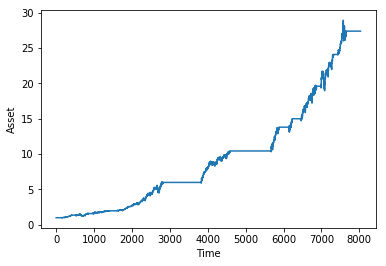

In [13]:
from matplotlib import pyplot as plt
plt.plot(backtest.history_asset)
plt.xlabel('Time')
plt.ylabel('Asset')
plt.show()